In [113]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


In [114]:
# 层类
class Relu:
    def forward(self,in_):
         self.in_ = in_
         out = np.maximum(0,in_)
         self.out = out
         return out  
    
    def __call__(self,in_):
        return self.forward(in_)
    
    def backward(self,dout): 
        grad = (self.in_>0).astype(int) * dout
        self.grad = grad
        return grad
    
class Sigmoid:
    def forward(self,in_):
         out = 1/(1+np.exp(-in_))
         self.out = out
         return out  
        
    def __call__(self,in_):
        return self.forward(in_)
    
    def backward(self,dout): 
        grad = self.out*(1-self.out)*dout
        self.grad = grad
        return grad

class Linear:
    """
    用于构建MLP的隐藏层和输出层的类
    """
    def __init__(self,input_size,output_size):
        """
        传入权重以及激活函数的类型来构建层：
            a_in: [batch_size,input_size]
            W: [input_size,output_size]
            a_in *  W: [batch_size,output_size]
            b: [ouput_size,]
        """
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros(output_size)

    def forward(self,in_):
        self.in_ = in_
        out = np.dot(in_,self.W) + self.b
        self.out = out
        return out
    
    def __call__(self,in_):
        return self.forward(in_)
    
    def backward(self,dout):
        grad_W = np.dot(self.in_.T,dout)
        grad_b = np.sum(dout,axis=0)
        self.grad_W,self.grad_b = grad_W,grad_b
        din_ = np.dot(dout,self.W.T)
        return din_
        
            


In [157]:
# 优化器

class SGD():
    def __init__(self,params,learning_rate=0.01,momentum=0.9,):
        self.lr = learning_rate
        self.momentum = momentum
        self.v_W = None
        self.v_b = None
    
    def update_params(self,layer,lambda_reg):
        
        # 如果动量项还没有初始化，则初始化为与权重和偏置相同的形状
        if self.v_W is None or self.v_b is None:
            self.v_W = np.zeros_like(layer.W)
            self.v_b = np.zeros_like(layer.b)

        # 更新动量项
        self.v_W = self.momentum*self.v_W + layer.grad_W
        self.v_b = self.momentum*self.v_b +layer.grad_b
        
        # 更新参数
        layer.W -= self.lr*(self.v_W+2*layer.W*lambda_reg)
        layer.b -= self.lr*self.v_b

    def __call__(self,layer,lambda_reg):
        self.update_params(layer,lambda_reg)


In [116]:
# 模型类
class MLP:
    """
    用于构建整个模型的类
    """
    def __init__(self,input_size,hidden_size,output_size):
        self.linear1 = Linear(input_size,hidden_size)
        self.relu = Relu()
        self.linear2 = Linear(hidden_size,output_size)
        self.sigmoid = Sigmoid()
    
    def forward(self,X):
        self.out1 = self.linear1(X)
        self.out2 = self.relu(self.out1)
        self.out3 = self.linear2(self.out2)
        self.out4 = self.sigmoid(self.out3)
        return self.out4
    
    def backward(self,dout):
        d3 = self.sigmoid.backward(dout)
        d2 = self.linear2.backward(d3)
        d1 = self.relu.backward(d2)
        self.linear1.backward(d1)

    def compute_loss(self,y,y_hat):
        epsilon = 1e-8  # 极小数，防止出现log(0)
        loss = -y*np.log(y_hat+epsilon) - (1-y) * np.log(1-y_hat+epsilon) # [batch_size,]
        loss = loss.mean() # 取得平均值
        return loss
    
    def compute_loss_grad(self,y,y_hat):
        return (y_hat - y.numpy())/len(y)
    

    def train(self,epochs,train_dataloader,optimizer,lambda_reg =  0):
        self.losses = [] # 记录每个epoch的训练损失
        for epoch in range(epochs):
            epoch_avg_loss = 0 #每个epoch的平均损失
            for batch_idx,(X,y) in enumerate(train_dataloader):
                # 前向传播
                y_hat = self.forward(X)

                # 计算损失
                loss = self.compute_loss(y,y_hat)
                regulation = ((self.linear1.W ** 2).sum() + (self.linear2.W ** 2).sum()) * lambda_reg / len(y_hat) 
                loss += regulation
                epoch_avg_loss += loss 

                # 计算损失函数梯度
                dout = self.compute_loss_grad(y,y_hat)

                # 反向传播
                self.backward(dout)

                # 更新参数
                optimizer[0](self.linear1,lambda_reg)
                optimizer[1](self.linear2,lambda_reg)
            
            epoch_avg_loss /= (batch_idx+1)
            self.losses.append(epoch_avg_loss)
    
    def learning_curve_show(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.losses) + 1), self.losses, 'bo-')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    
    def evaluate(self,test_dataloader,lambda_reg):
        correct_num_sum =0
        test_loss = 0
        for batch_idx,(X,y) in enumerate(test_dataloader):
            y_hat = self.forward(X)
            loss = self.compute_loss(y,y_hat)
            regulation = ((self.linear1.W ** 2).sum() + (self.linear2.W ** 2).sum()) * lambda_reg / len(y_hat) 
            loss += regulation
            test_loss+=loss
            y_hat_class = (y_hat > 0.5).astype(int)
            correct_num_batch = (y_hat_class==y.numpy()).sum()
            correct_num_sum += correct_num_batch
        test_loss /= (batch_idx+1)
        acc = (correct_num_sum / len(test_dataloader.dataset))*100
        return test_loss,acc



In [117]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # 确保索引在范围内
        if idx >= len(self.data):
            raise IndexError("Index out of range")
        
        sample = self.data.iloc[idx].values  # 按行号索引数据
        label = self.labels.iloc[idx].values 
        """
        此处data为dataFrame类型,labels为Series类型
        dataFrame和series类型经过切片之后均为series类型
        此处.values将他们转换为numpy数组类型
        """

        return sample, label

def Standardization(data):
    """
    标准化函数:将一组数据转化为均值为0,标准差为1的标准正态分布
    """
    return (data-data.mean())/data.std()
def Normolization(data):
    """
    归一化函数：将一组数据按比例缩放到(0,1)
    """
    return (data-data.min())/(data.max()-data.min())

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    将原有数据集拆分成数据集与测试集的函数
    X: 特征向量
    y: 标签值
    test_size: test数据集占整个数据集的比例
    randem_state: 随机种子
    """

    # 设置随机种子
    if random_state is not None:
        np.random.seed(random_state)
    
    # 确定测试集的大小（样本数）
    num_test = int(len(X) * test_size)
    
    # 生成随机索引
    indices = np.random.permutation(len(X))
    
    # 切分数据集
    X_train = X.iloc[indices[num_test:]]
    X_test = X.iloc[indices[:num_test]]
    y_train = y.iloc[indices[num_test:]]
    y_test = y.iloc[indices[:num_test]]
    
    return X_train, X_test, y_train, y_test

def data_preprocess(data_raw):
    """
    数据预处理函数：
        我们通过补中位数的方式,对age列进行补全
        我们通过补众数的方式来,对Embarked进行补全
        由于cabin缺了大部分数据,所以我们直接用U代表Unkown对其进行填补
    """
    # 数据补全与特征缩放
    data_raw['Age'].fillna(data_raw['Age'].median(),inplace=True)
    data_raw['Embarked'] = data_raw['Embarked'].fillna(data_raw['Embarked'].mode().iloc[0]) 
    data_raw['Cabin'].fillna('U',inplace=True)
    data_raw['Age']  = Standardization(data_raw['Age'])
    data_raw['Fare']  = Standardization(data_raw['Fare'])

    # 标签
    target = ['Survived'] 
    y = data_raw[target]
    # 用于预测的特征
    fetures = ['Pclass','Sex','Age','Fare','Parch','SibSp','Embarked'] 
    X = pd.get_dummies(data_raw[fetures],dtype=int)
    
    return X,y

In [118]:
# 主程序

# 读取数据集
data_raw = pd.read_csv("..\week1\dataProcess\泰坦尼克号数据.csv")

# 数据预处理
X, y = data_preprocess(data_raw)

# 将数据集拆分成训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 制作数据集
train_set = MyDataset(X_train, y_train)
test_set = MyDataset(X_test, y_test)

# 构造dataLoader
batch_size = 32
train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, num_workers=0)


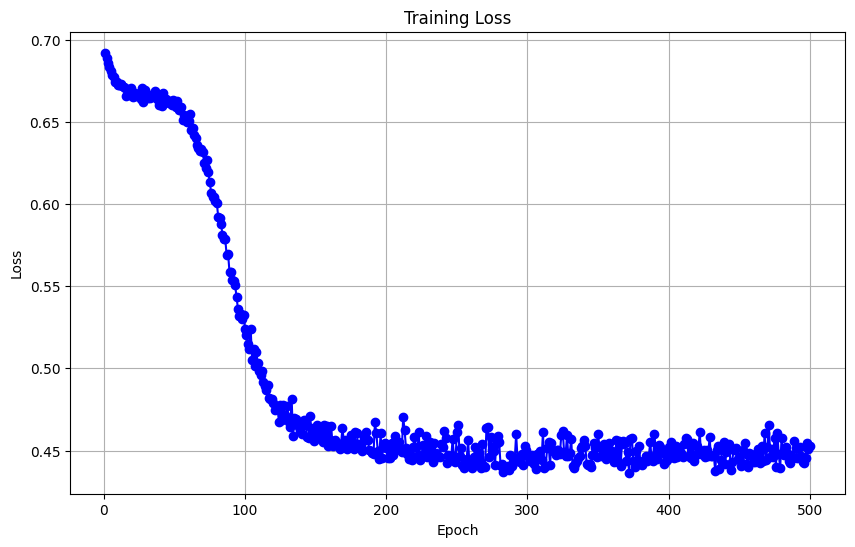

In [155]:
learning_rate = 5e-3
optimizer1 = SGD(learning_rate,momentum=0.9)
optimizer2 = SGD(learning_rate,momentum=0.9)
mlp = MLP(input_size=10,hidden_size=3,output_size=1)
mlp.train(epochs=500,train_dataloader=train_dataloader,lambda_reg=0,optimizer=[optimizer1,optimizer2])
mlp.learning_curve_show()


In [158]:
# 测试
test_loss,accuracy = mlp.evaluate(test_dataloader,lambda_reg=0)
print(f"accracy:{accuracy:.2f}%     loss:{test_loss:.4f}")

accracy:81.46%     loss:0.4143


In [122]:
# a=np.array([[1],[0],[1]]) * 1000
# linear1 = Linear(batch_size=3,
#                  feature_size=1,
#                  unit=3)
# print(linear1.W,linear1.b)
# print(linear1(a,is_train=True))
# print(linear1.grad_W,linear1.grad_b)

# relu = Relu()
# sigmoid = Sigmoid()
# print(sigmoid(linear1.out))
# print(sigmoid.grad)

# b=np.array([[0.8],[0.5],[0.7]])
# compute_BinaryCrossEntropy(a,b)

# a_in = np.array([[1,-3],
#                  [3,-5],
#                  [5,-6]]) # 3*2

# W_1= np.array([[1,2,3],
#               [1,2,3]]) # 2*3

# b_1 = np.array([[1,2,3],
#               [4,5,6],
#               [7,8,9]]) # 3*3

# W_2 = np.array([[1],
#                 [-1],
#                 [0]]) # 上一层的输入为 3*3, 3*1
# b_2 = np.array([[5],
#                 [-8],
#                 [-11]])               # 3*1 

# layer1 = Layer(W_1,b_1,activation='linear')
# layer2 = Layer(W_2,b_2,activation='linear')
# layers = [layer1,layer2]
# # a_out1 = layer1(a_in)
# # print(f"a_out1 = \n{a_out1}")
# # a_out2 = layer2(a_out1)
# # print(f"a_out2 = \n{a_out2}")

# model = Model(layers)
# model.train(a_in)

In [123]:
# for i in range(10):
#     print(i)
